<center> <h1> Learning Multivariate New Physics </h1> </center>

<br>


Link: [Paper](https://arxiv.org/abs/1912.12155)

Contents:

- Variable naming recap table
- Code useful to create and test virtual GPUs (used on LCSL01)
- Generation of figures 6-7 from the paper
- Code useful to load saved models for future figure generation
- Summary of future works proposed in the paper

## Variable naming recap table

As used in the code by Gaia Grosso
<br>

<table style="width:100%">
<tr>
    <td></td>
    <td><b>Paper</b></td>
    <td><b>Code</b></td>
    <td><b>Comments</b></td>
</tr>
<tr>
    <td><b>Number of expected background events</b></td>
    <td>$ \text{N(R)} $</td>
    <td>N_Bkg, N_D</td>
    <td>Expected events in the data sample according to the reference model</td>
</tr>
<tr>
    <td><b>Number of actual background events</b></td>
    <td>$ B $</td>
    <td>N_Bkg_p</td>
    <td>Number of samples drawn from $p(x|\text{R})$ to be used in the data sample.</td>
</tr>
<tr>
    <td><b>Number of expected signal events</b></td>
    <td>$ \text{N(S)} $</td>
    <td>N_Sig</td>
    <td>Expected events in the data sample according to the signal model</td>
</tr>
<tr>
    <td><b>Number of actual signal events</b></td>
    <td>$ S $</td>
    <td>N_Sig_p</td>
    <td>Number of samples drawn from $p(x|\text{S})$ to be used in the data sample.</td>
</tr>
<tr>
    <td><b>Reference sample size</b></td>
    <td>$\mathcal{N_R}$</td>
    <td>N_ref, N_R</td>
    <td>Simply considered as $B+S$</td>
</tr>
<tr>
    <td><b>Data sample size</b></td>
    <td>-</td>
    <td>-</td>
</tr>
<tr>
    <td><b>Reference sample</b></td>
    <td>$\mathcal{R}$</td>
    <td>Reference</td>
    <td>Variable created after training. HLF_REF is used to include both $\mathcal{R}$ and $B$, sampled at once
    from (the file emulating) $p(x|\text{R})$</td>
</tr>
<tr>
    <td><b>Data sample</b></td>
    <td>$\mathcal{D}$</td>
    <td>Data</td>
    <td>Variable created after training. HLF_SIG is used to include $S$ samples drawn
    from (the file emulating) $p(x|\text{S})$</td>
</tr>
</table>

<br>

## Code useful to create and test virtual GPUs

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  1


In [3]:
type(gpus[0])

tensorflow.python.eager.context.PhysicalDevice

In [3]:
# Create 2 virtual GPUs with 1GB memory each

tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=300) for i in range(3)])
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")

1 Physical GPU, 3 Logical GPUs


In [14]:
logical_gpus = tf.config.experimental.list_logical_devices('GPU')

c = []
for gpu in logical_gpus:
    with tf.device(gpu.name):
        a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
        c.append(tf.matmul(a, b))
        
print(c)

[<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[22., 28.],
       [49., 64.]], dtype=float32)>, <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[22., 28.],
       [49., 64.]], dtype=float32)>]


## Figure 6-7 generation

<br>

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

def BuildSample_DY(N_Events, INPUT_PATH, seed, nfiles=20):
    """
    Load dataset of size N_events from one or multiple
    .h5 files

    Parameters
    ----------
    N_events: int
        number of events to consider

    INPUT_PATH:
        path of the file

    seed:
        seed to use

    nfiles: int, optional
        random integer to select Zprime file between nfiles
        (default is 20)

    Returns
    ----------
    HLF: np.ndarray (N_events x 6)
        Training set for the model with features:
        [PT1, PT2, ETA1, ETA2, DELTA_PHI, MASS]

    """

    #random integer to select Zprime file between n files                                                                                                                                                             
    u = np.arange(nfiles)#np.random.randint(100, size=100)                                                                                                                                                            
    np.random.shuffle(u)

    #BACKGROUND                                                                                                                                                                                                       
    #extract N_Events from files                                                                                                                                                                                      
    toy_label = INPUT_PATH.split("/")[-2] # folder name
    print("Data folder: {}".format(toy_label))

    HLF = np.array([])

    for u_i in u:
        f = h5py.File(INPUT_PATH+toy_label+str(u_i+1)+".h5", 'r')
        keys=f.keys()
        #check whether the file is empty                                                                                                                                                                              
        if len(keys)==0:
            continue
        cols=np.array([])
        for i in range(len(keys)):
            feature = np.array(f.get(list(keys)[i]))
            feature = np.expand_dims(feature, axis=1)
            if i==0:
                cols = feature
            else:
                cols = np.concatenate((cols, feature), axis=1)
        print("File {}/{} size: {}".format(u_i+1, nfiles, cols.shape))
        np.random.shuffle(cols) #don't want to select always the same event first                                                                                                                                     

        if HLF.shape[0]==0:
            HLF=cols
            i=i+1
        else:
            HLF=np.concatenate((HLF, cols), axis=0)
        f.close()
        #print(HLF_REF.shape)

        # take only a given number of events                                                                                                                                                                                         
        if HLF.shape[0]>=N_Events:
            HLF=HLF[:N_Events, :]
            break                                                                                                                                                                                               
    #print(HLF.shape)
    
    # feature order: pt1, pt2, eta1, eta2, delta_phi, mass
    return HLF[:, [4, 5, 1, 2, 0, 3]]

## Z' to di-muon

In [3]:
# SM di-muon reference data samples
INPUT_PATH_BKG = 'data/DiLepton_SM/'
nfile_REF = 66 # number of files in REF repository

#random seed
seed=42
np.random.seed(seed)
print('Random seed:'+str(seed))
print('------------------------\n')

print('REFERENCE SAMPLE + BACKGROUND\n')
# Variables used to generate random samples
N_Bkg = 20000   # N(R) in the figure
N_ref = 100000  # reference sample size
print('Reference sample size: '+str(N_ref))

# POISSON FLUCTUATIONS around the expected numbers N(R)
N_Bkg_P = np.random.poisson(lam=N_Bkg, size=1)
N_Bkg_p = N_Bkg_P[0]
print('Number of expected events according to the reference model: '+str(N_Bkg))
print('Actual Background events, considering Poisson fluctuations: '+str(N_Bkg_p))

#BACKGROUND+REFERENCE
# Extract $ \mathcal{N_R} $ + (Poisson fluctuations around $ N(R) $) samples from the file emulating p(x|R)
HLF_REF = BuildSample_DY(N_Events=N_ref+N_Bkg_p, INPUT_PATH=INPUT_PATH_BKG, seed=seed, nfiles=nfile_REF)
print("Reference sample + Background events shape: {}".format(HLF_REF.shape))

Random seed:42
------------------------

REFERENCE SAMPLE + BACKGROUND

Reference sample size: 100000
Number of expected events according to the reference model: 20000
Actual Background events, considering Poisson fluctuations: 19949
Data folder: DiLepton_SM
File 47/66 size: (57584, 6)
File 17/66 size: (57448, 6)
File 5/66 size: (57441, 6)
Reference sample + Background events shape: (119949, 6)


In [3]:
INPUT_PATH_SIG = 'data/DiLepton_Zprime200/'

nfile_SIG = 1 #number of files in SIG repository


N_Sig = 5       # N(S) in the figure


print('m_Z\' = 200 GeV\n')

# POISSON FLUCTUATIONS around the expected numbers:
N_Sig_P = np.random.poisson(lam=N_Sig, size=1)
N_Sig_p = N_Sig_P[0]
print('Expected signal samples: '+str(N_Sig))
print('Actual signal samples, considering Poisson fluctuations: '+str(N_Sig_p))

HLF_SIG_1 = BuildSample_DY(N_Events=N_Sig_p, INPUT_PATH=INPUT_PATH_SIG, seed=seed, nfiles=nfile_SIG)
print('Signal samples size: {}'.format(HLF_SIG_1.shape))

m_Z' = 200 GeV

Expected signal samples: 5
Actual signal samples, considering Poisson fluctuations: 3
Data folder: DiLepton_Zprime200
File 1/1 size: (48138, 6)
Signal samples size: (3, 6)


In [4]:
INPUT_PATH_SIG = 'data/DiLepton_Zprime300/'

nfile_SIG = 1 #number of files in SIG repository


N_Sig = 35       # N(S) in the figure

print('m_Z\' = 300 GeV\n')

# POISSON FLUCTUATIONS around the expected numbers:
N_Sig_P = np.random.poisson(lam=N_Sig, size=1)
N_Sig_p = N_Sig_P[0]
print('Expected signal samples: '+str(N_Sig))
print('Actual signal samples, considering Poisson fluctuations: '+str(N_Sig_p))

HLF_SIG_2 = BuildSample_DY(N_Events=N_Sig_p, INPUT_PATH=INPUT_PATH_SIG, seed=seed, nfiles=nfile_SIG)
print('Signal samples size: {}'.format(HLF_SIG_2.shape))

m_Z' = 300 GeV

Expected signal samples: 35
Actual signal samples, considering Poisson fluctuations: 36
Data folder: DiLepton_Zprime300
File 1/1 size: (43000, 6)
Signal samples size: (36, 6)


In [5]:
INPUT_PATH_SIG = 'data/DiLepton_Zprime600/'

nfile_SIG = 1 #number of files in SIG repository


N_Sig = 70       # N(S) in the figure

print('m_Z\' = 600 GeV\n')

# POISSON FLUCTUATIONS around the expected numbers:
N_Sig_P = np.random.poisson(lam=N_Sig, size=1)
N_Sig_p = N_Sig_P[0]
print('Expected signal samples: '+str(N_Sig))
print('Actual signal samples, considering Poisson fluctuations: '+str(N_Sig_p))

HLF_SIG_3 = BuildSample_DY(N_Events=N_Sig_p, INPUT_PATH=INPUT_PATH_SIG, seed=seed, nfiles=nfile_SIG)
print('Signal samples size: {}'.format(HLF_SIG_3.shape))

m_Z' = 600 GeV

Expected signal samples: 70
Actual signal samples, considering Poisson fluctuations: 62
Data folder: DiLepton_Zprime600
File 1/1 size: (37127, 6)
Signal samples size: (62, 6)


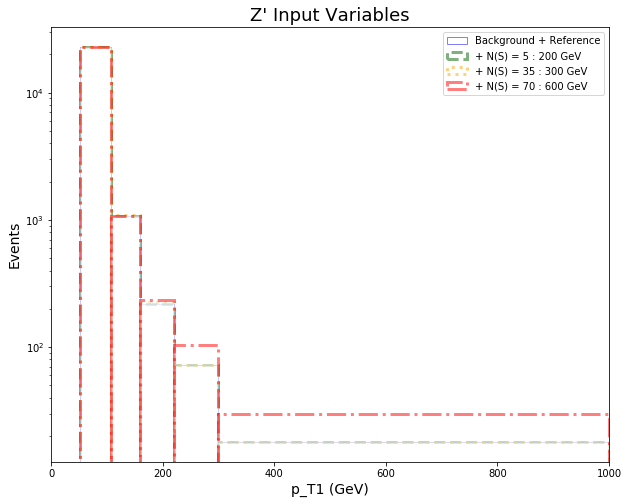

In [9]:
# p_T1
i = 0

ref = HLF_REF[:,i]
s1 = np.hstack((ref, HLF_SIG_1[:,i]))
s2 = np.hstack((ref, HLF_SIG_2[:,i]))
s3 = np.hstack((ref,HLF_SIG_3[:,i]))

bins = [52, 107, 160, 220, 300, 1000]

plt.figure(figsize=(10,8))
plt.hist((ref), bins = bins, color='w', alpha=0.5, edgecolor='blue', label='Background + Reference')
plt.hist((s1), bins = bins, color='w', alpha=0.5, edgecolor='darkgreen', ls='dashed', lw=3, label='+ N(S) = 5 : 200 GeV ')
plt.hist((s2), bins = bins, color='w', alpha=0.5, edgecolor='orange', ls='dotted', lw=3, label='+ N(S) = 35 : 300 GeV')
plt.hist((s3), bins = bins, color='w', alpha=0.5, edgecolor='red', ls='dashdot', lw=3, label='+ N(S) = 70 : 600 GeV')
plt.xlim([0,1000])
plt.yscale('log', nonposy='clip')
plt.title('Z\' Input Variables', fontsize=18)
plt.xlabel('p_T1 (GeV)', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.legend()
plt.show()

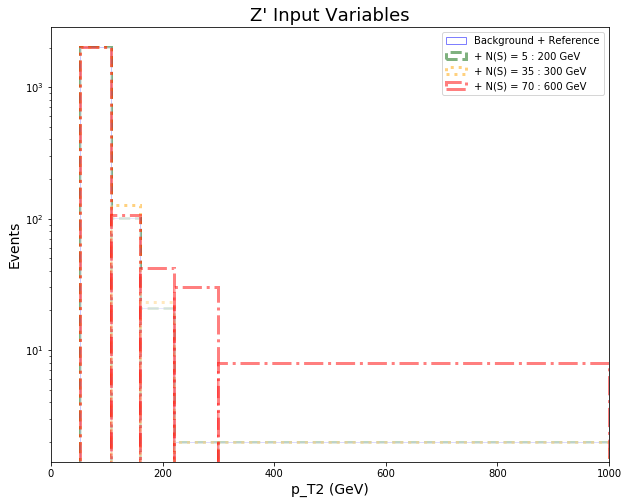

In [10]:
# p_T2
i = 1

ref = HLF_REF[:,i]
s1 = np.hstack((ref, HLF_SIG_1[:,i]))
s2 = np.hstack((ref, HLF_SIG_2[:,i]))
s3 = np.hstack((ref,HLF_SIG_3[:,i]))

bins = [52, 107, 160, 220, 300, 1000]

plt.figure(figsize=(10,8))
plt.hist((ref), bins = bins, color='w', alpha=0.5, edgecolor='blue', label='Background + Reference')
plt.hist((s1), bins = bins, color='w', alpha=0.5, edgecolor='darkgreen', ls='dashed', lw=3, label='+ N(S) = 5 : 200 GeV ')
plt.hist((s2), bins = bins, color='w', alpha=0.5, edgecolor='orange', ls='dotted', lw=3, label='+ N(S) = 35 : 300 GeV')
plt.hist((s3), bins = bins, color='w', alpha=0.5, edgecolor='red', ls='dashdot', lw=3, label='+ N(S) = 70 : 600 GeV')
plt.xlim([0,1000])
plt.yscale('log', nonposy='clip')
plt.title('Z\' Input Variables', fontsize=18)
plt.xlabel('p_T2 (GeV)', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.legend()
plt.show()

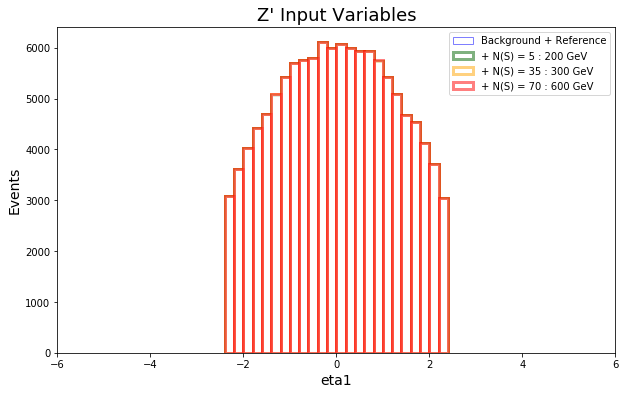

In [17]:
# eta1
i = 2

ref = HLF_REF[:,i]
s1 = np.hstack((ref, HLF_SIG_1[:,i]))
s2 = np.hstack((ref, HLF_SIG_2[:,i]))
s3 = np.hstack((ref,HLF_SIG_3[:,i]))

bins = 24

plt.figure(figsize=(10,6))
plt.hist((ref), bins = bins, color='w', alpha=0.5, edgecolor='blue', label='Background + Reference')
plt.hist((s1), bins = bins, color='w', alpha=0.5, edgecolor='darkgreen',  lw=3, label='+ N(S) = 5 : 200 GeV ')
plt.hist((s2), bins = bins, color='w', alpha=0.5, edgecolor='orange',  lw=3, label='+ N(S) = 35 : 300 GeV')
plt.hist((s3), bins = bins, color='w', alpha=0.5, edgecolor='red',  lw=3, label='+ N(S) = 70 : 600 GeV')
plt.xlim([-6,6])
plt.title('Z\' Input Variables', fontsize=18)
plt.xlabel('eta1', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.legend()
plt.show()

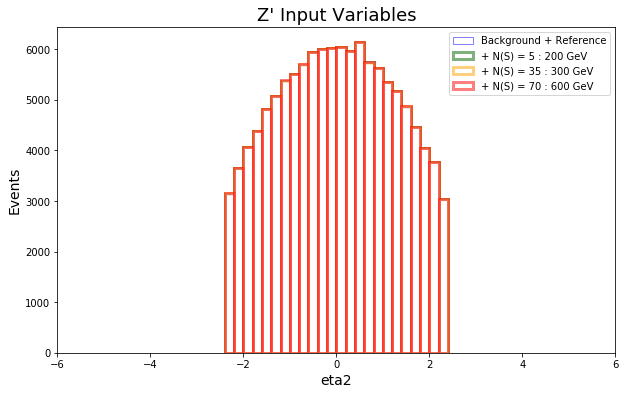

In [119]:
# eta2
i = 3

ref = HLF_REF[:,i]
s1 = np.hstack((ref, HLF_SIG_1[:,i]))
s2 = np.hstack((ref, HLF_SIG_2[:,i]))
s3 = np.hstack((ref,HLF_SIG_3[:,i]))

bins = 24

plt.figure(figsize=(10,6))
plt.hist((ref), bins = bins, color='w', alpha=0.5, edgecolor='blue', label='Background + Reference')
plt.hist((s1), bins = bins, color='w', alpha=0.5, edgecolor='darkgreen',  lw=3, label='+ N(S) = 5 : 200 GeV ')
plt.hist((s2), bins = bins, color='w', alpha=0.5, edgecolor='orange',  lw=3, label='+ N(S) = 35 : 300 GeV')
plt.hist((s3), bins = bins, color='w', alpha=0.5, edgecolor='red',  lw=3, label='+ N(S) = 70 : 600 GeV')
plt.xlim([-6,6])
plt.title('Z\' Input Variables', fontsize=18)
plt.xlabel('eta2', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.legend()
plt.show()

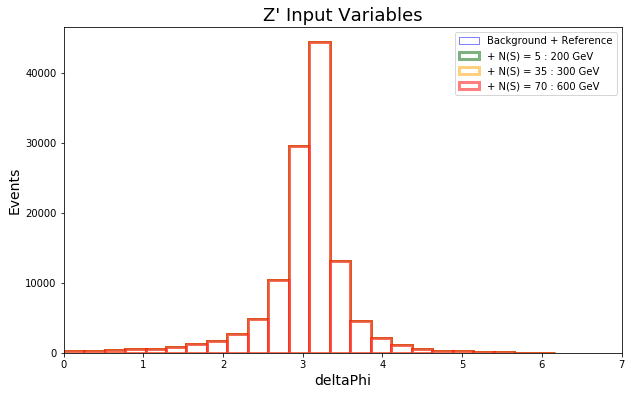

In [120]:
# deltaPhi
i = 4

ref = HLF_REF[:,i]
s1 = np.hstack((ref, HLF_SIG_1[:,i]))
s2 = np.hstack((ref, HLF_SIG_2[:,i]))
s3 = np.hstack((ref,HLF_SIG_3[:,i]))

bins = 24

plt.figure(figsize=(10,6))
plt.hist((ref), bins = bins, color='w', alpha=0.5, edgecolor='blue', label='Background + Reference')
plt.hist((s1), bins = bins, color='w', alpha=0.5, edgecolor='darkgreen',  lw=3, label='+ N(S) = 5 : 200 GeV ')
plt.hist((s2), bins = bins, color='w', alpha=0.5, edgecolor='orange',  lw=3, label='+ N(S) = 35 : 300 GeV')
plt.hist((s3), bins = bins, color='w', alpha=0.5, edgecolor='red',  lw=3, label='+ N(S) = 70 : 600 GeV')
plt.xlim([0,7])
plt.title('Z\' Input Variables', fontsize=18)
plt.xlabel('deltaPhi', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.legend()
plt.show()

The plots are (maybe) intented to show how the sole signal component alter the histograms of each single features. Slight differences can be observed only in the first two plots.

## Code useful to load saved models

In [2]:
import keras.backend as K
from keras.models import Model, load_model
from keras import optimizers
from keras.constraints import Constraint
import json
import matplotlib.pyplot as plt

from nn_model import *

Using TensorFlow backend.


In [3]:
# LOAD the neural network

file_path = 'C:/Users/gvlos/Desktop/AUK/cluster/Multivariate NP/output'
N_D = 100000
N_R = 5*N_D

NN = load_model(file_path + '/nn_0.h5', custom_objects={'WeightClip': WeightClip}, compile=False)
NN.compile(loss = return_custom_loss(N_D, N_R), \
                  optimizer='adam')
print(NN.summary())

# Uncomment to LOAD the training history
history_dict = json.load(open(file_path + '/hist_0.json', 'r'))
print("Total training iterations: {}".format(len(history_dict['loss'])))

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 5)                 0         
_________________________________________________________________
dense_73 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_74 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_75 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 6         
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________
None
Total training iterations: 100


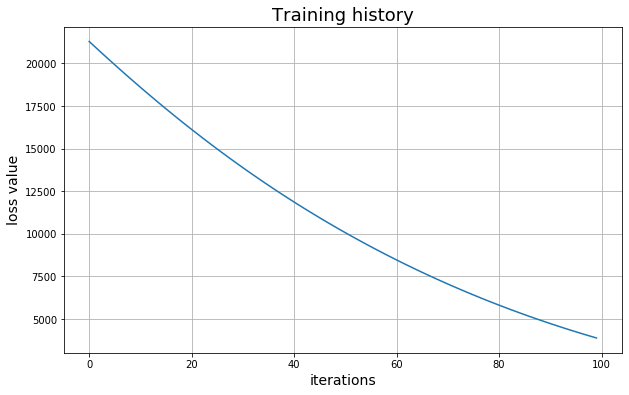

In [4]:
loss_values = history_dict['loss']
iterations = np.arange(len(loss_values))

plt.figure(figsize=(10,6))
plt.plot(iterations,loss_values)
plt.title('Training history', fontsize=18)
plt.xlabel('iterations', fontsize=14)
plt.ylabel('loss value', fontsize=14)
plt.grid()
plt.show()

## Future works

- **Inclusion of the systematic uncertainties in the reference (SM) Monte Carlo**

    The most pressing aspect to be explored in view of the application of our strategy to real data is the inclusion of the systematic
    uncertainties in the reference (SM) Monte Carlo as nuisance parameters. The concrete implementation of
    the algorithm in the presence of nuisance parameters requires two steps:
    1. The first one is to fit the nuisance parameters under the SM hypothesis to the observed data, including auxiliary
      measurements. Since this first step is the same as in any other experimental analysis, it
      should not pose any specific issue.
    2. Implementing the second step is instead problematic because
        it would require running the Monte Carlo with the nuisance parameters set to the observed
        best-fit value. Doing so for many toy SM datasets would be computationally very demanding or
        unfeasible. Potential solutions are either to obtain the reference sample by reweighting (which
        will require fitting the dependence on the nuisance of the SM likelihood possibly with a neural
        network) or to employ a reference sample with benchmark nuisance and correct the test statistics
        by some approximation of the ratio between the best-fit and the benchmark SM likelihood.
        It is important to verify if and how these solutions work in practice.
        

- **Performance evaluation on realistic LHC dataset**

    Compare performances (e.g. sensitivity) to other model-independent strategies recently proposed in the literature with respect to realistic LHC datasets (instead of simple toy models).

- **Performance evaluation of the method in absolute terms: correlation between ideal and observed significance**

    The probability to observe a tension with the SM (if the data follow the new
    physics distribution) as a function of the ideal median significance of the putative new physics signal is used as an objective
    measure of how “easy-to-  detect” the new physics scenario is. (Notice that the ideal significance is not the target of our method since the ideal significance     can be reached, because of the Neyman–Pearson lemma, only in a fully model-dependent search
    where all the details of the new physics scenario are known and cannot be obtained with any
    model-independent approach.) Comparing the observed and ideal
    significance, we observe a good correlation between the ideal and observed significance in a given experiment and a weak dependence on the type of signal     that is responsible for the discrepancy. This behavior might have a deep explanation, which is worth
    trying to identify. Yet another direction for future work is the assessment of the performances
    presented for more complex final states than dimuon and for more exotic putative signals.

- **Hyperparameters selection improvement**

    The main methodological advance consists of a strategy to select the
    hyperparameters associated with the neural network and its training, prior to the experiment,
    and without relying on assumptions on the nature of the putative new physics signal.The one we propose is heuristic, but convincing, and reduces
    the ensemble of hyperparameters choices to a manageable level. 

    $\implies $Progress might come on this aspect from a more sharp notion of neural network “flexibility” (or Capacity). Notice however
    that the concrete impact of the hyperparameters on the sensitivity to new physics signal has been
    observed to be extremely limited in all the examples we studied. Even if no systematic study
    has been performed, this suggests that residual ambiguities in the hyperparameters selection
    could be ignored.

<br>